# Hate Speech Detection using Deep Learning

This project is an NLP-based sequence classification model to classify tweets as Hate Speech, Offensive Language or Neutral.

In [1]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

## Loading The Data

Important to note the class field in the dataset compromises of the set (0, 1, 2)
- 0: Hate Speech - content explicitly targeting individuals or groups with harmful intent
- 1: Offensive Language - content containing offensive language but not necessarily hate speech
- 2: Neutral - content without any offensive or hateful intent

In [2]:
df = pd.read_csv('hate_speech.csv')
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
df.shape

(24783, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


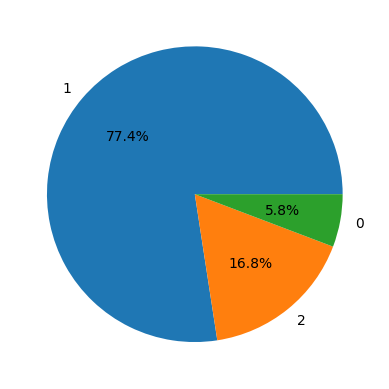

In [5]:
plt.pie(df['class'].value_counts().values,
        labels = df['class'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

We see from this visualization that most of the tweets (77.4%) in our dataset are labelled as Offensive. While only 5.8% of our data contains tweets under the target class "Hate Speech".

Let's balance the dataset using upsampling and downsampling!

Note, for simplicity we are going to oversample class_0 by duplication which may lead to overfitting due to repeated examples.

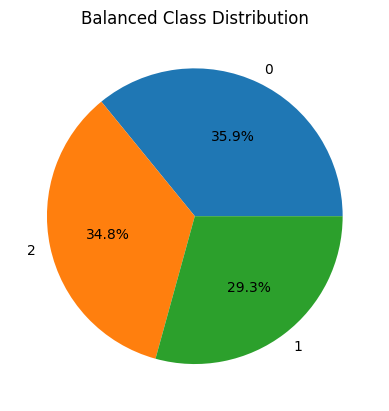

In [6]:
class_0 = df[df['class'] == 0]  # Hate Speech
class_1 = df[df['class'] == 1].sample(n=3500, random_state=42)  # Offensive Language
class_2 = df[df['class'] == 2]  # Neutral

balanced_df = pd.concat([class_0, class_0, class_0, class_1, class_2], axis=0, ignore_index=True)

# Visualize the balanced distribution
plt.pie(balanced_df['class'].value_counts().values,
        labels=balanced_df['class'].value_counts().index,
        autopct='%1.1f%%')
plt.title("Balanced Class Distribution")
plt.show()

## Text Preprocessing

Our tweets are highly unstructured and need attention on many aspects like Stopword removal, Punctuation removal, Stemming and Lemmatization

In [8]:
df['tweet'] = df['tweet'].str.lower()

punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

df['tweet']= df['tweet'].apply(lambda x: remove_punctuations(x))

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(words)

balanced_df['tweet'] = balanced_df['tweet'].apply(preprocess_text)

df.head()

,class,tweet
0,2,rt mayasolovely as a woman you shouldnt compl...
1,1,rt mleew17 boy dats coldtyga dwn bad for cuff...
2,1,rt urkindofbrand dawg rt 80sbaby4life you eve...
3,1,rt cganderson vivabased she look like a tranny
4,1,rt shenikaroberts the shit you hear about me ...


Now lets visualise the most frequent words present in the corpus of the data using WordCloud

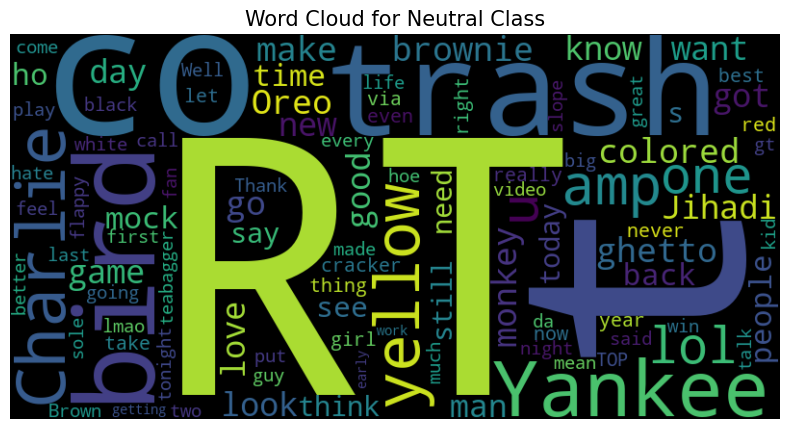

In [9]:
def plot_word_cloud(data, typ):
    corpus = " ".join(data['tweet'])
    wc = WordCloud(max_words=100, width=800, height=400, collocations=False).generate(corpus)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {typ} Class", fontsize=15)
    plt.show()

plot_word_cloud(balanced_df[balanced_df['class'] == 2], typ="Neutral")

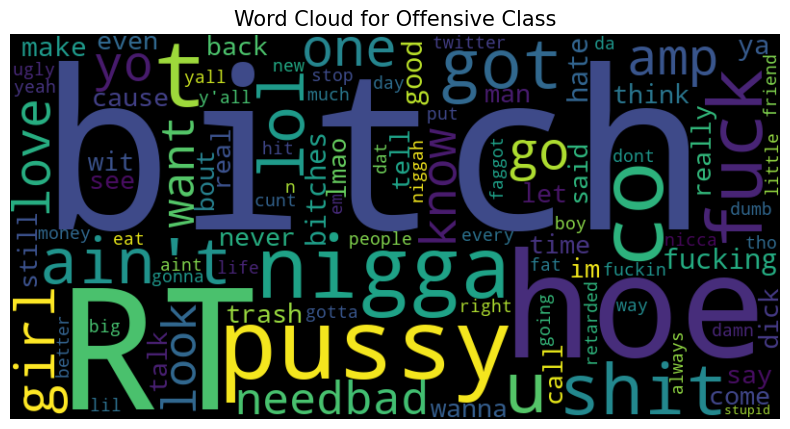

In [10]:
plot_word_cloud(balanced_df[balanced_df['class'] == 1], typ="Offensive")

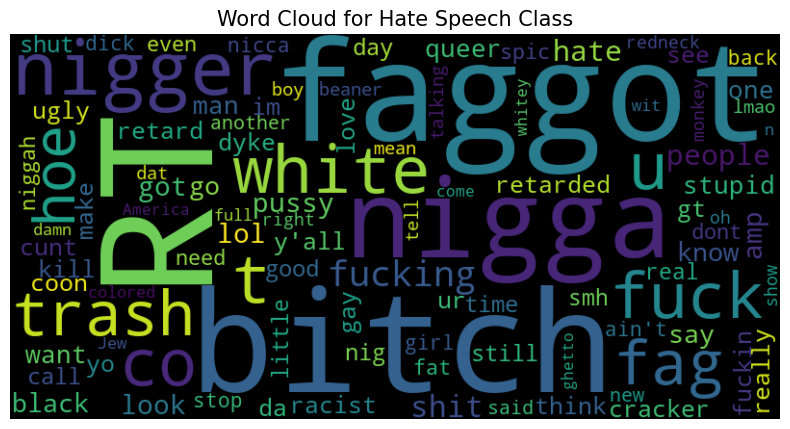

In [11]:
plot_word_cloud(balanced_df[balanced_df['class'] == 0], typ="Hate Speech")

## Tokenisation and Padding

In [12]:
features = balanced_df['tweet']
target = balanced_df['class']
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# One-hot encode the labels
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)

# Tokenization
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

## Model Development

We will implement a Sequential model like LSTM which will contain the following parts:
- Embedding Layers to learn a featured vector representations of the input vectors.
- Bidirectional LSTM layer to identify useful patterns in the sequence.
- We have included BatchNormalization layers to enable stable and fast training and a Dropout layer before the final layer to avoid any possibility of overfitting.

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

max_words = 10000
max_len = 100 

model = keras.models.Sequential([
    layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_len),
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dense(512, activation='relu', kernel_regularizer='l1'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  
])

model.build(input_shape=(None, max_len))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,755 (1.32 MB)

 Trainable params: 345,731 (1.32 MB)

 Non-trainable params: 1,024 (4.00 KB)

## Model Training

In [14]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit(X_train_padded, Y_train,
                    validation_data=(X_val_padded, Y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[es, lr])

Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.6480 - loss: 3.8566 - val_accuracy: 0.6336 - val_loss: 0.9832 - learning_rate: 0.0010
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - accuracy: 0.9057 - loss: 0.3662 - val_accuracy: 0.7085 - val_loss: 0.7289 - learning_rate: 0.0010
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - accuracy: 0.9419 - loss: 0.2599 - val_accuracy: 0.8331 - val_loss: 0.5783 - learning_rate: 0.0010
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.9482 - loss: 0.2246 - val_accuracy: 0.8423 - val_loss: 0.5546 - learning_rate: 0.0010
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - accuracy: 0.9657 - loss: 0.1748 - val_accuracy: 0.8699 - val_loss: 0.5314 - learning_rate: 0.0010
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.9769 - loss: 0.1325 - val_accuracy: 0.8829 - val_loss: 0.4927 - learning_rate: 0.0010
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - accuracy: 0.9788 - l

## Model Evaluation

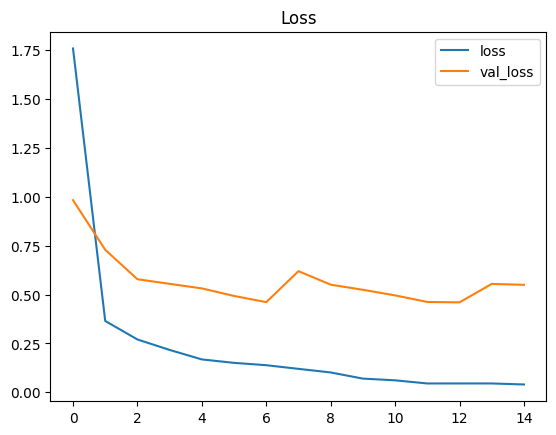

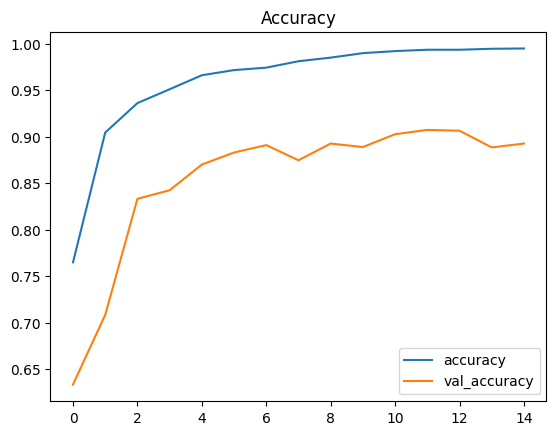

In [15]:
history_df = pd.DataFrame(history.history)

history_df[['loss', 'val_loss']].plot(title="Loss")

history_df[['accuracy', 'val_accuracy']].plot(title="Accuracy")
plt.show()

In [16]:
test_loss, test_acc = model.evaluate(X_val_padded, Y_val)
print(f"Validation Accuracy: {test_acc:.2f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9104 - loss: 0.4666
Validation Accuracy: 0.91


The trained model achieves 91% accuracy on the validation set, demonstrating the effectiveness of deep learning techniques like LSTM for hate speech detection. While the model shows some overfitting, regularization techniques can be applied to improve generalization.